In [2]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

if torch.cuda.is_available():
    GPU_SCORE = torch.cuda.get_device_capability()
    if GPU_SCORE >= (8, 0):
        torch.backends.cuda.matmul.allow_tf32 = True

Classe: Cyprinidae


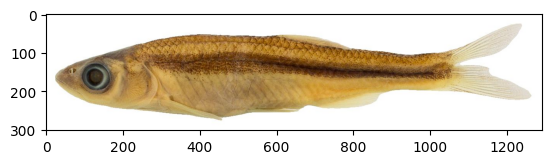

In [3]:
from PIL import Image
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the the fish_vista_repo_dir to the path of your cloned fish-vista HF repository
fish_vista_repo_dir = "dataset/fish-vista/"

# Read classification test and train csv files
train_path = os.path.join(fish_vista_repo_dir, "classification_train.csv")
train_df = pd.read_csv(train_path)

test_path = os.path.join(fish_vista_repo_dir, "classification_test.csv")
test_df = pd.read_csv(test_path)

# Get image at index 'idx'
idx = 5
classes = sorted(train_df.family.drop_duplicates())

class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
img_class = train_df.iloc[idx].family
img_filename = train_df.iloc[idx].file_name

img_test = Image.open(os.path.join(fish_vista_repo_dir, img_filename))
plt.imshow(img_test)
print(f"Classe: {img_class}")

In [4]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

class FishDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.img_labels = dataframe["standardized_species"].unique()
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe["filename"])

    def __getitem__(self, idx):
        label = class_to_idx[self.dataframe.iloc[idx].family]
        img_filename = self.dataframe.iloc[idx].file_name
        image = Image.open(self.root_dir + img_filename)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [22]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(144, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

toTensorTransform = transforms.Compose([
    transforms.Resize(size=(144, 512)),
    transforms.ToTensor()
])

In [6]:
BATCH_SIZE = 64
WORKERS = 0
train_dataset = FishDataset(train_df,fish_vista_repo_dir,data_transform)
test_dataset = FishDataset(test_df,fish_vista_repo_dir,toTensorTransform)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=WORKERS, 
                              shuffle=True,
                              generator=torch.Generator(device=device)) 

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=WORKERS, 
                             shuffle=False,
                             generator=torch.Generator(device=device))

In [10]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9*32,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

#model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)
model = torchvision.models.resnet50().to(device)
num_ftrs =  model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
#for param in model.parameters():
    #param.requires_grad = False
#for param in model.fc.parameters():
    #param.requires_grad = True
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [8]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
      # 1. Forward pass
        y_pred = model(X)

      # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

      # 3. Optimizer zero grad
        optimizer.zero_grad()

      # 4. Loss backward
        loss.backward()

      # 5. Optimizer step
        optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [26]:
import torchinfo
EPOCHS = 20
print(torchinfo.summary(model,(1,3,512,144)))
train(model,train_dataloader,test_dataloader,optimizer,loss_fn,EPOCHS,device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 122]                  --
├─Conv2d: 1-1                            [1, 64, 256, 72]          9,408
├─BatchNorm2d: 1-2                       [1, 64, 256, 72]          128
├─ReLU: 1-3                              [1, 64, 256, 72]          --
├─MaxPool2d: 1-4                         [1, 64, 128, 36]          --
├─Sequential: 1-5                        [1, 256, 128, 36]         --
│    └─Bottleneck: 2-1                   [1, 256, 128, 36]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 36]          4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 36]          128
│    │    └─ReLU: 3-3                    [1, 64, 128, 36]          --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 36]          36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 36]          128
│    │    └─ReLU: 3-6                    [1, 64, 128, 36]          --
│ 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1060 | train_acc: 0.9665 | test_loss: 0.2805 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.0751 | train_acc: 0.9753 | test_loss: 0.2389 | test_acc: 0.9438
Epoch: 3 | train_loss: 0.0640 | train_acc: 0.9789 | test_loss: 4.8090 | test_acc: 0.4001
Epoch: 4 | train_loss: 0.0657 | train_acc: 0.9786 | test_loss: 0.3273 | test_acc: 0.9106
Epoch: 5 | train_loss: 0.0586 | train_acc: 0.9806 | test_loss: 0.2351 | test_acc: 0.9421
Epoch: 6 | train_loss: 0.0614 | train_acc: 0.9785 | test_loss: 0.5846 | test_acc: 0.8860
Epoch: 7 | train_loss: 0.0587 | train_acc: 0.9803 | test_loss: 0.2431 | test_acc: 0.9438
Epoch: 8 | train_loss: 0.0573 | train_acc: 0.9809 | test_loss: 2.6765 | test_acc: 0.5409
Epoch: 9 | train_loss: 0.0514 | train_acc: 0.9813 | test_loss: 0.2816 | test_acc: 0.9366
Epoch: 10 | train_loss: 0.0547 | train_acc: 0.9820 | test_loss: 0.3058 | test_acc: 0.9218
Epoch: 11 | train_loss: 0.0471 | train_acc: 0.9836 | test_loss: 0.2778 | test_acc: 0.9432
Epoch: 12 | train_l

{'train_loss': [0.10602623302527323,
  0.07512767761009247,
  0.06402390036363381,
  0.06569104904437359,
  0.058599719073626856,
  0.061362934915685674,
  0.058728587912692864,
  0.05730108997326626,
  0.05139037007461663,
  0.05473530925922027,
  0.047061984229023565,
  0.04389033723110075,
  0.03995789553067128,
  0.03952446654282177,
  0.037854082387531816,
  0.04240961356925765,
  0.033140749748318536,
  0.033715950329964155,
  0.03947806768755109,
  0.030411366363849862],
 'train_acc': [0.9665325655169817,
  0.9752852247910234,
  0.9789264298892989,
  0.9785716639054146,
  0.9805808278108291,
  0.978522832103321,
  0.9802748936290384,
  0.980915590405904,
  0.9813191881918819,
  0.9820110701107011,
  0.9836254612546126,
  0.9842596863468634,
  0.9862111934257097,
  0.9862976786655622,
  0.9864129923186987,
  0.9852975092250923,
  0.9883156675954514,
  0.9881915289178402,
  0.9862776752767528,
  0.9893646688380149],
 'test_loss': [0.28050115434774037,
  0.23893061553625838,
  4.80

In [27]:
# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, 
                 exist_ok=True 
)

# Create model save path
MODEL_NAME = "ecowave.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\ecowave.pth


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


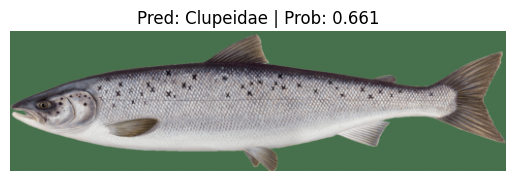

In [39]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    target_image = Image.open(image_path).convert("RGB")

    if transform:
        target_image = transform(target_image)
    
    target_image = target_image
    
    model.to(device)
    
    #Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) 
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

pred_and_plot_image(model,"testImage.png",classes,toTensorTransform,device)